In [1]:
from taming.models.vqgan import VQModel

import sys
from PIL import Image
import matplotlib.pyplot as plt
sys.path.append(".")
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

def preprocess(img, target_image_size=256, map_dalle=True):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    if map_dalle: 
      img = map_pixels(img)
    return img


In [3]:
config1024 = load_config("../pretrain/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
model1024 = load_vqgan(config1024, ckpt_path="../pretrain/vqgan_imagenet_f16_1024/ckpts/last.ckpt").to(DEVICE)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/umut/anaconda3/envs/maskgit/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
model1024.quantize

VectorQuantizer2(
  (embedding): Embedding(1024, 256)
)

In [5]:
test_image_file = "/home/umut/Desktop/MaskGIT/Project/Data/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_18.JPEG"
image = Image.open(test_image_file)

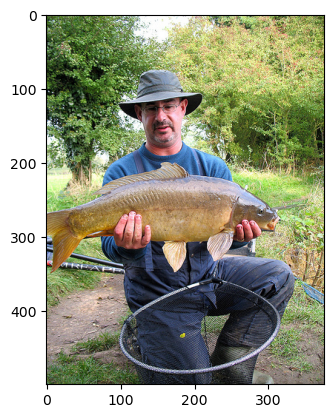

In [6]:
plt.imshow(image)
plt.show()

In [7]:
x_vqgan = preprocess(image, target_image_size=320, map_dalle=False).to(DEVICE)

In [8]:
res = model1024.encode(x_vqgan)

In [9]:
res[0].shape

torch.Size([1, 256, 20, 20])

In [10]:
import torchvision.transforms as T

In [11]:
resizer = T.RandomResizedCrop(size=(256, 256))

In [12]:
im2 = resizer(image)

In [13]:
arr = np.array(im2)

NameError: name 'np' is not defined

In [ ]:
arr.shape